<a href="https://colab.research.google.com/github/Saroramath/MachineLearning/blob/main/6206A/6205A5TempDataRNN24Hrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning goals

1. Prepare the time series data into samples.
2. We will us primitive commands to understand the sample generation steps.

In [82]:
!pip install netCDF4

In [83]:
from netCDF4 import Dataset
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [84]:
from google.colab import files
#uploaded = files.upload()

In [85]:
#drive.mount('/content/gdrive')

> The file is too big to call as raw from github or to use upload. 

Upload the file in sample_data directory from system.

In [86]:
file = '/content/sample_data/tempStJohns.nc'

# Explore the data

In [87]:
df = Dataset(file)

In [88]:
df

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2021-02-03 00:49:51 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/data2/adaptor.mars.internal-1612306467.0641284-4955-27-685dbd6e-9572-4267-a9a7-5a61b7e919e4.nc /cache/tmp/685dbd6e-9572-4267-a9a7-5a61b7e919e4-adaptor.mars.internal-1612306467.0646257-4955-9-tmp.grib
    dimensions(sizes): longitude(1), latitude(1), expver(2), time(87672)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 t2m(time, expver, latitude, longitude)
    groups: 

In [89]:
df['longitude'][0] #longitude of the place

masked_array(data=-52.75,
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [90]:
df['time'] # Time series units: hours since 1900-01-01 00:00:00.0

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (87672,)
filling on, default _FillValue of -2147483647 used

In [91]:
time = df['time'][:] #start value 973008, end value 1060679

In [92]:
time

masked_array(data=[ 973008,  973009,  973010, ..., 1060677, 1060678,
                   1060679],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [93]:
time.shape

(87672,)

> Consider columns with time data

In [94]:
 df['t2m'][:,0,0,0]

masked_array(data=[272.81080791804084, 272.6567134137989,
                   272.7837285490946, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-32767)

> Convert to Celsius

In [95]:
temp = df['t2m'][:,0,0,0]-273.15

> Masked arrays are arrays that may have missing or invalid entries. The numpy.ma module provides a nearly work-alike replacement for numpy that supports data arrays with masks.



In [96]:
temp 

masked_array(data=[-0.3391920819591405, -0.4932865862010658,
                   -0.36627145090540125, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-32767)

 The array is masked, filled with -32767 for the missing values, mask tells us where is that happeneing.

In [97]:
temp.data 

array([-3.39192082e-01, -4.93286586e-01, -3.66271451e-01, ...,
       -3.27670000e+04, -3.27670000e+04, -3.27670000e+04])

In [98]:
temp.shape

(87672,)

In [99]:
temp.mask

array([False, False, False, ...,  True,  True,  True])

## Rmoving masked values.

First we check if the masked values are continuous or not.

In [100]:
missing = np.where(temp.mask == True)

In [101]:
missing[0][0] # The missing data is infact continuous so our time series is not broken anywhere

86928

In [102]:
temp = temp[~temp.mask] #use the inverse of the mask as an index.

In [103]:
temp.shape # This is a continuous time series for temperature.

(86928,)

Reducing time seris to match with it

In [104]:
time = time[:86928]

In [105]:
time.shape

(86928,)

Find the unique value in numpy

In [106]:
np.unique(temp.mask) #All values are genuine now

array([False])

## Plot the temperature over time.

Plot the time series against time




In [107]:
number_of_years = (time-973008)/8760 

Temperature plot over approximately 10 years

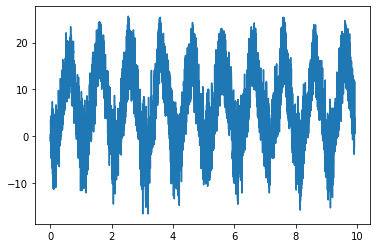

In [108]:
plt.plot(number_of_years,temp)

## Standardize the temperature

In [109]:
temp.shape

(86928,)

In [110]:
temp.mean()

5.57589982331033

In [111]:
temp.std()

7.754305350561417

(array([  297.,  2100.,  6706., 15629., 17035., 14113., 12733., 11795.,
         5601.,   919.]),
 array([-16.62485352, -12.39963379,  -8.17441406,  -3.94919434,
          0.27602539,   4.50124512,   8.72646484,  12.95168457,
         17.1769043 ,  21.40212402,  25.62734375]),
 <a list of 10 Patch objects>)

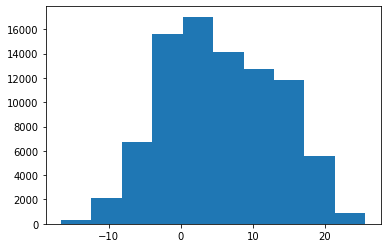

In [112]:
plt.hist(temp)

In [113]:
#temp = (temp - temp.mean())/temp.std()

In [114]:
temp.mean()

5.57589982331033

In [115]:
temp.std()

7.754305350561417

In [116]:
temp.max()

25.627343750000023

In [117]:
temp.min()

-16.624853515624977

## Generate Samples

We will avoid using functions to generate smaples to understand the process.

We want the prediction model to predict the next 6 hr of data with previous 6 hrs of temp data available.

In [118]:
temp[0:6]

masked_array(data=[-0.3391920819591405, -0.4932865862010658,
                   -0.36627145090540125, -0.1728473870034577,
                   -0.26569093767636787, -0.4346146201507963],
             mask=[False, False, False, False, False, False],
       fill_value=-32767)

We make the vectors of size 6

In [119]:
future = 6
past = 24

In [120]:
data = []

for i in range(len(temp)- (future + past)  +1):
  data.append(temp[i:i+past].data)
data  = np.array(data) 

In [121]:
label = []
for i in range(len(temp)- (future + past)  +1):
  label.append(temp[i+ past:i+past + future].data)

label = np.array(label)


In [122]:
#no of samples
n_dataSample = len(temp)-past-future +1
print(n_dataSample)

86899


In [123]:
data.shape

(86899, 24)

In [124]:
label.shape

(86899, 6)

> Split the samples into train and test data

In [125]:
temp_train_number = np.int(0.8*len(data))

In [126]:
temp_train_number

69519

In [127]:
train_temp = data[:temp_train_number]

In [128]:
train_temp.shape

(69519, 24)

In [129]:
train_temp[temp_train_number-1]

array([-3.81502251, -3.31792267, -3.32501488, -2.65383338, -2.5977404 ,
       -2.45525134, -2.08452189, -2.08903511, -2.09096935, -1.99554682,
       -1.93300637, -1.8537025 , -1.38819526, -1.04003194, -0.77310673,
       -0.56485349, -0.4797469 , -0.47200994, -0.68284217, -0.84338414,
       -1.15157315, -1.24312721, -1.32629955, -1.44493298])

In [130]:
train_label = label[:temp_train_number]

In [131]:
train_label.shape

(69519, 6)

In [132]:
test_temp = data[temp_train_number:]

In [133]:
test_label = label[temp_train_number:]

In [134]:
print(test_label.shape)
print(test_temp.shape)

(17380, 6)
(17380, 24)


In [135]:
test_temp[1].shape

(24,)

#  Persistence Model

In [136]:
def model_persistence(test_temp_entry):
  arr = np.full((future,),test_temp_entry[past-1])

  return arr

In [137]:
test_temp[1]

array([-3.32501488, -2.65383338, -2.5977404 , -2.45525134, -2.08452189,
       -2.08903511, -2.09096935, -1.99554682, -1.93300637, -1.8537025 ,
       -1.38819526, -1.04003194, -0.77310673, -0.56485349, -0.4797469 ,
       -0.47200994, -0.68284217, -0.84338414, -1.15157315, -1.24312721,
       -1.32629955, -1.44493298, -1.40689291, -1.32952329])

In [138]:
model_persistence(test_temp[1])

array([-1.32952329, -1.32952329, -1.32952329, -1.32952329, -1.32952329,
       -1.32952329])

In [139]:
def y_persis(test_temp):
  arr = np.empty(test_label.shape)
  for i in range(len(test_temp)):
    arr[i] = model_persistence(test_temp[i])
  return arr    

In [140]:
test_temp.shape

(17380, 24)

In [141]:
y_persistence = y_persis(test_temp)

### MSE_Persistence

In [142]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [143]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_persistence))
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_persistence))

Mean squared error: 2.91
Coefficient of determination: 0.95


### Plot the temp

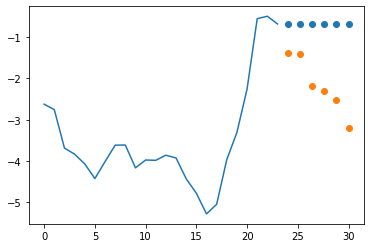

In [144]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[101])
plt.scatter(z,y_persistence[101])
plt.scatter(z,test_label[101])

# Linear regression using Sklearn

In [145]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [146]:
linear_regression = linear_model.LinearRegression()

In [147]:
linear_regression.fit(train_temp, train_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [148]:
predict_label = linear_regression.predict(test_temp)

### MSE_Linear_Regression

In [149]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, predict_label))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, predict_label))

Mean squared error: 1.81
Coefficient of determination: 0.97


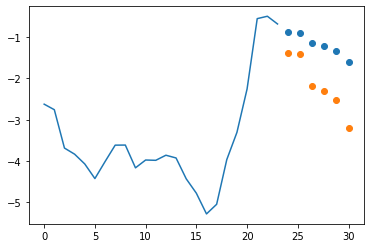

In [150]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[101])
plt.scatter(z,predict_label[101])
plt.scatter(z,test_label[101])

# Neural Network

## Normalize the data

In [151]:
train_temp_max = train_temp.max()
train_temp_min = train_temp.min()

train_temp_norm = (train_temp- train_temp_min)/(train_temp_max-train_temp_min)
test_temp_norm = (test_temp- train_temp_min)/(train_temp_max-train_temp_min)

train_label_norm = (train_label- train_temp_min)/(train_temp_max-train_temp_min)
test_label_norm = (test_label- train_temp_min)/(train_temp_max-train_temp_min)



In [152]:
train_temp.max()

25.627343750000023

In [153]:
train_label.min()

-16.624853515624977

In [154]:
#inp = tf.keras.layers.Input(shape=(6,))     # Sequential api
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
##b = tf.keras.layers.Dense(128,activation='relu')(inp)
#b = tf.keras.layers.Dense(128,activation='relu')(inp)
#out = tf.keras.layers.Dense(6, activation='linear')(b)

#model = tf.keras.models.Model(inp,out)
#model.summary()

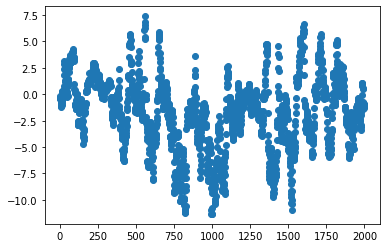

In [155]:
axis = np.linspace(0,1999,2000)
axisy = temp[0:2000]
plt.scatter(axis,axisy)

## Model

In [156]:
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Input(shape=(past,)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(future, activation='linear')
])

# Compile the model, i.e. associate a loss function and the chosen variant of GD
model.compile(
    loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),'accuracy']
)

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3200      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 36,998
Trainable params: 36,998
Non-trainable params: 0
_________________________________________________________________


In [157]:
test = test_temp_norm, test_label_norm

In [158]:
hist = model.fit(train_temp_norm,train_label_norm ,batch_size=64, epochs=40,callbacks = tf.keras.callbacks.EarlyStopping(patience=5), validation_data= test)

Epoch 1/40
1087/1087 [==============================] - 4s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0471 - accuracy: 0.3320 - val_loss: 0.0013 - val_mean_absolute_error: 0.0261 - val_accuracy: 0.4287
Epoch 2/40
1087/1087 [==============================] - 3s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0259 - accuracy: 0.4360 - val_loss: 0.0012 - val_mean_absolute_error: 0.0252 - val_accuracy: 0.4922
Epoch 3/40
1087/1087 [==============================] - 3s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0253 - accuracy: 0.4505 - val_loss: 0.0012 - val_mean_absolute_error: 0.0248 - val_accuracy: 0.4577
Epoch 4/40
1087/1087 [==============================] - 3s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0244 - accuracy: 0.4565 - val_loss: 0.0011 - val_mean_absolute_error: 0.0246 - val_accuracy: 0.4853
Epoch 5/40
1087/1087 [==============================] - 3s 3ms/step - loss: 0.0012 - mean_absolute_error: 0.0242 - accuracy: 0.4593 - val_loss: 9.9738e-04 - val_mean_ab

In [159]:
test_temp

array([[-3.31792267, -3.32501488, -2.65383338, ..., -1.32629955,
        -1.44493298, -1.40689291],
       [-3.32501488, -2.65383338, -2.5977404 , ..., -1.44493298,
        -1.40689291, -1.32952329],
       [-2.65383338, -2.5977404 , -2.45525134, ..., -1.40689291,
        -1.32952329, -1.26891708],
       ...,
       [ 6.44612408,  6.50479605,  6.37262294, ...,  2.18370246,
         2.84908124,  3.12825664],
       [ 6.50479605,  6.37262294,  6.03413082, ...,  2.84908124,
         3.12825664,  3.38099741],
       [ 6.37262294,  6.03413082,  4.70337326, ...,  3.12825664,
         3.38099741,  3.79363542]])

In [160]:
prediction = model.predict(test_temp_norm)

In [161]:
prediction.shape

(17380, 6)

In [162]:
test_label_norm.shape

(17380, 6)

In [163]:
model.evaluate(test_temp_norm,  test_label_norm, verbose=2)

544/544 - 0s - loss: 0.0010 - mean_absolute_error: 0.0225 - accuracy: 0.5570


[0.0010244733421131968, 0.02251298725605011, 0.5570195913314819]

## Scale back to prediction temperature

In [164]:
y_predict_norm = model.predict(test_temp_norm)

In [165]:
y_predict = train_temp_min + y_predict_norm * (train_temp_max-train_temp_min)

##MSE_Neural_Network

In [166]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict))

Mean squared error: 1.83
Coefficient of determination: 0.97


## Plot the temp

In [167]:
z = np.linspace(past, past+future,future)

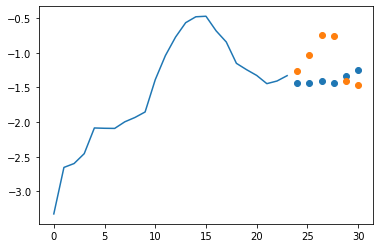

In [168]:
i = 1
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i])
plt.scatter(z,test_label[i]) # What shappeneing is that predicted values are so large in comparison to the test amd label values that is approximately starilght line

# Model comparison


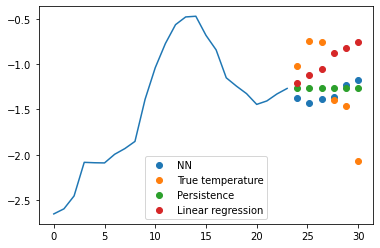

In [169]:
i = 2
z = np.linspace(past, past+future,future)
plt.plot(test_temp[i])
plt.scatter(z,y_predict[i], label = 'NN')
plt.scatter(z,test_label[i], label = 'True temperature')
plt.scatter(z,y_persistence[i], label= 'Persistence')
plt.scatter(z,predict_label[i], label='Linear regression')
#plt.scatter(z,y_predict_LR[i], label='Linear regression in Keras')

plt.legend(loc='best')



## MSE

> We will check how MSE grows for predicted value on time axis.

In [170]:
def mse(predict):
  mse = np.ones((future,))
  for i in range(future):
     mse[i]= np.mean((test_label[:,i]-predict[:,i])**2)
  return mse 
   

In [171]:
mse(y_persistence)

array([0.35980473, 1.07395306, 2.08032862, 3.28121692, 4.64615857,
       6.03035874])

In [172]:
mse(predict_label)

array([0.22839943, 0.6234303 , 1.21430255, 1.97920815, 2.91432841,
       3.89220089])

In [173]:
mse(test_label) #test

array([0., 0., 0., 0., 0., 0.])

In [174]:
mse(y_predict) #NN

array([0.28344046, 0.72505499, 1.36267274, 2.1420189 , 2.80520046,
       3.65523926])

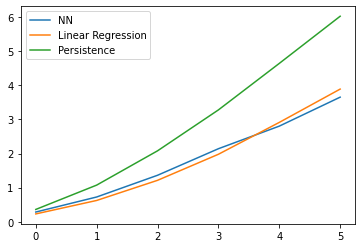

In [175]:
plt.plot(mse(y_predict), label = 'NN')
plt.plot(mse(predict_label), label = 'Linear Regression')
plt.plot(mse(y_persistence), label = 'Persistence')
#plt.plot(mse(y_predict2), label = 'NN2')
#plt.plot(mse(y_predict3), label = 'NN3')
plt.legend(loc='best')

# Asignment 5 New Models

> We still need to run previous cells as data samples are generated there and some of the libraries are imported there.

## Reshape the data

> For RNN models, we need to reshape the data 

In [176]:
train_temp_new = np.expand_dims(train_temp_norm, axis = 2)
test_temp_new = np.expand_dims(test_temp_norm, axis = 2)

In [177]:
train_label_new = np.expand_dims(train_label_norm, axis = 2)
test_label_new = np.expand_dims(test_label_norm, axis = 2)

# LSTM model

In [178]:
LSTM_model = tf.keras.Sequential([
  
    tf.keras.layers.InputLayer(input_shape=(past,1)),
    tf.keras.layers.LSTM(32, return_sequences=False),
    
    tf.keras.layers.Dense(future,
                          kernel_initializer=tf.initializers.zeros()),
    
    tf.keras.layers.Reshape([future,1])
])



In [179]:
LSTM_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy','mse'],
)
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
reshape (Reshape)            (None, 6, 1)              0         
Total params: 4,550
Trainable params: 4,550
Non-trainable params: 0
_________________________________________________________________


In [180]:
history = LSTM_model.fit(train_temp_new,train_label_new, epochs=20)

Epoch 1/20
2173/2173 [==============================] - 26s 11ms/step - loss: 0.0215 - accuracy: 3.3419e-05 - mse: 0.0215
Epoch 2/20
2173/2173 [==============================] - 24s 11ms/step - loss: 0.0018 - accuracy: 4.5361e-05 - mse: 0.0018
Epoch 3/20
2173/2173 [==============================] - 24s 11ms/step - loss: 0.0014 - accuracy: 3.1533e-05 - mse: 0.0014
Epoch 4/20
2173/2173 [==============================] - 24s 11ms/step - loss: 0.0013 - accuracy: 1.5761e-05 - mse: 0.0013
Epoch 5/20
2173/2173 [==============================] - 24s 11ms/step - loss: 0.0012 - accuracy: 4.7479e-05 - mse: 0.0012
Epoch 6/20
2173/2173 [==============================] - 24s 11ms/step - loss: 0.0012 - accuracy: 2.0799e-05 - mse: 0.0012
Epoch 7/20
2173/2173 [==============================] - 23s 11ms/step - loss: 0.0012 - accuracy: 3.7262e-05 - mse: 0.0012
Epoch 8/20
2173/2173 [==============================] - 23s 11ms/step - loss: 0.0011 - accuracy: 2.2265e-05 - mse: 0.0011
Epoch 9/20
2173/2173 [==

In [181]:
LSTM_model.evaluate(test_temp_new,  test_label_new, verbose=2)

544/544 - 2s - loss: 9.7849e-04 - accuracy: 0.0000e+00 - mse: 9.7849e-04


[0.0009784885914996266, 0.0, 0.0009784880094230175]

## Scale back to prediction temperature

In [182]:
y_predict_new = LSTM_model.predict(test_temp_new)

In [183]:
y_predict_new.shape

(17380, 6, 1)

In [184]:
y_predict_LSTM = train_temp_min + y_predict_new * (train_temp_max-train_temp_min)

##MSE_LSTM

> First Method

In [185]:
test_label_back= np.expand_dims(test_label, 2)

In [186]:
y_predict_LSTM.shape

(17380, 6, 1)

In [187]:
((y_predict_LSTM - test_label_back)**2).mean() # MSE in temperature terms

1.7468450898670729

> Second Method 

In order to use the MSE method of sklearn we rehape it back reducing dimension. 

In [188]:
y_predict_LSTM_reshaped = y_predict_LSTM.reshape(-1,6)

In [189]:
y_predict_LSTM_reshaped.shape

(17380, 6)

In [190]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict_LSTM_reshaped))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict_LSTM_reshaped))

Mean squared error: 1.75
Coefficient of determination: 0.97


## Plot the temp

In [191]:
z = np.linspace(past, past+future,future)

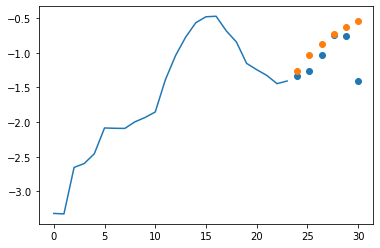

In [192]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[0])
plt.scatter(z,test_label[0])
plt.scatter(z,y_predict_LSTM_reshaped[0])

# RNN Network

In [193]:
RNN_model = tf.keras.Sequential([
  
    tf.keras.layers.InputLayer(input_shape=(past,1)),
    tf.keras.layers.SimpleRNN(128, return_sequences=True),
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    
    tf.keras.layers.Dense(future,
                          kernel_initializer=tf.initializers.zeros()),
    
    tf.keras.layers.Reshape([future,1])
])

In [194]:
RNN_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy','mse'],
)
RNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 24, 128)           16640     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                12352     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
_________________________________________________________________
reshape_1 (Reshape)          (None, 6, 1)              0         
Total params: 29,382
Trainable params: 29,382
Non-trainable params: 0
_________________________________________________________________


In [195]:
history = RNN_model.fit(train_temp_new,train_label_new, epochs=20)

Epoch 1/20
2173/2173 [==============================] - 32s 14ms/step - loss: 0.0179 - accuracy: 2.1243e-05 - mse: 0.0179
Epoch 2/20
2173/2173 [==============================] - 31s 14ms/step - loss: 0.0015 - accuracy: 2.1203e-05 - mse: 0.0015
Epoch 3/20
2173/2173 [==============================] - 30s 14ms/step - loss: 0.0013 - accuracy: 3.9933e-05 - mse: 0.0013
Epoch 4/20
2173/2173 [==============================] - 31s 14ms/step - loss: 0.0012 - accuracy: 2.5785e-05 - mse: 0.0012
Epoch 5/20
2173/2173 [==============================] - 30s 14ms/step - loss: 0.0012 - accuracy: 3.3589e-05 - mse: 0.0012
Epoch 6/20
2173/2173 [==============================] - 30s 14ms/step - loss: 0.0012 - accuracy: 2.5134e-05 - mse: 0.0012
Epoch 7/20
2173/2173 [==============================] - 30s 14ms/step - loss: 0.0011 - accuracy: 2.6904e-05 - mse: 0.0011
Epoch 8/20
2173/2173 [==============================] - 31s 14ms/step - loss: 0.0011 - accuracy: 2.0003e-05 - mse: 0.0011
Epoch 9/20
2173/2173 [==

In [196]:
RNN_model.evaluate(test_temp_new,  test_label_new, verbose=2)

544/544 - 3s - loss: 0.0010 - accuracy: 0.0000e+00 - mse: 0.0010


[0.0010447994573041797, 0.0, 0.0010447994573041797]

## Scale back to prediction temperature

In [197]:
y_predict_new = RNN_model.predict(test_temp_new)

In [198]:
y_predict_new.shape

(17380, 6, 1)

In [199]:
y_predict_RNN = train_temp_min + y_predict_new * (train_temp_max-train_temp_min)

##MSE_RNN

> First Method

In [200]:
test_label_back= np.expand_dims(test_label, 2)

In [201]:
y_predict_RNN.shape

(17380, 6, 1)

In [202]:
((y_predict_RNN - test_label_back)**2).mean() # MSE in temperature terms

1.8652271736941868

> Second Method 

In order to use the MSE method of sklearn we rehape it back reducing dimension. 

In [203]:
y_predict_RNN_reshaped = y_predict_RNN.reshape(-1,6)

In [204]:
y_predict_RNN_reshaped.shape

(17380, 6)

In [205]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict_RNN_reshaped))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict_RNN_reshaped))

Mean squared error: 1.87
Coefficient of determination: 0.97


## Plot the temp

In [206]:
z = np.linspace(past, past+future,future)

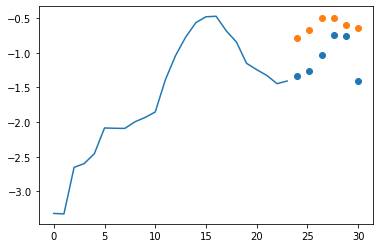

In [207]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[0])
plt.scatter(z,test_label[0])
plt.scatter(z,y_predict_RNN_reshaped[0])

# GRU Model

In [208]:
GRU_model = tf.keras.Sequential([
  
    tf.keras.layers.InputLayer(input_shape=(past,1)),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.SimpleRNN(128, return_sequences=False),



    
    tf.keras.layers.Dense(future,
                          kernel_initializer=tf.initializers.zeros()),
    
    tf.keras.layers.Reshape([future,1])
])



In [209]:
GRU_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy','mse'],
)
GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 24, 128)           50304     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
_________________________________________________________________
reshape_2 (Reshape)          (None, 6, 1)              0         
Total params: 83,974
Trainable params: 83,974
Non-trainable params: 0
_________________________________________________________________


In [210]:
history = GRU_model.fit(train_temp_new,train_label_new, epochs=20)

Epoch 1/20
2173/2173 [==============================] - 70s 31ms/step - loss: 0.0098 - accuracy: 3.1756e-05 - mse: 0.0098
Epoch 2/20
2173/2173 [==============================] - 68s 31ms/step - loss: 0.0012 - accuracy: 4.4239e-05 - mse: 0.0012
Epoch 3/20
2173/2173 [==============================] - 68s 31ms/step - loss: 0.0012 - accuracy: 2.1455e-05 - mse: 0.0012
Epoch 4/20
2173/2173 [==============================] - 69s 32ms/step - loss: 0.0012 - accuracy: 1.8890e-05 - mse: 0.0012
Epoch 5/20
2173/2173 [==============================] - 69s 32ms/step - loss: 0.0012 - accuracy: 1.9308e-05 - mse: 0.0012
Epoch 6/20
2173/2173 [==============================] - 70s 32ms/step - loss: 0.0011 - accuracy: 1.9592e-05 - mse: 0.0011
Epoch 7/20
2173/2173 [==============================] - 69s 32ms/step - loss: 0.0011 - accuracy: 3.7457e-05 - mse: 0.0011
Epoch 8/20
2173/2173 [==============================] - 68s 31ms/step - loss: 0.0011 - accuracy: 2.4015e-05 - mse: 0.0011
Epoch 9/20
2173/2173 [==

In [211]:
GRU_model.evaluate(test_temp_new,  test_label_new, verbose=2)

544/544 - 5s - loss: 9.3654e-04 - accuracy: 0.0000e+00 - mse: 9.3654e-04


[0.0009365412988699973, 0.0, 0.0009365418227389455]

## Scale back to prediction temperature

In [212]:
y_predict_new = GRU_model.predict(test_temp_new)

In [213]:
y_predict_new.shape

(17380, 6, 1)

In [214]:
y_predict_GRU = train_temp_min + y_predict_new * (train_temp_max-train_temp_min)

##MSE_GRU

> First Method

In [215]:
test_label_back= np.expand_dims(test_label, 2)

In [216]:
y_predict_GRU.shape

(17380, 6, 1)

In [217]:
((y_predict_GRU - test_label_back)**2).mean() # MSE in temperature terms

1.6719592820945208

> Second Method 

In order to use the MSE method of sklearn we rehape it back reducing dimension. 

In [218]:
y_predict_GRU_reshaped = y_predict_LSTM.reshape(-1,6)

In [219]:
y_predict_GRU_reshaped.shape

(17380, 6)

In [220]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict_GRU_reshaped))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict_GRU_reshaped))

Mean squared error: 1.75
Coefficient of determination: 0.97


## Plot the temp

In [221]:
z = np.linspace(past, past+future,future)

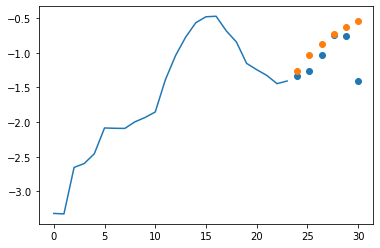

In [222]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[0])
plt.scatter(z,test_label[0])
plt.scatter(z,y_predict_GRU_reshaped[0])

# Wavenet Network

In [223]:
WAV_model = tf.keras.Sequential([        # 4 layers good for looking back at the 64 hrs of the data #put input shape= (None,19) for any sequence.
    tf.keras.layers.InputLayer(input_shape=(past,1)),
tf.keras.layers.Conv1D(filters=16,
                           kernel_size=(2,),
                           activation='relu',padding= 'causal' , dilation_rate = 1),
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=(2,),
                           activation='relu',padding= 'causal' ,  dilation_rate = 2),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', padding= 'causal' , dilation_rate = 4),
     tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(past,),
                           activation='relu' , dilation_rate = 1),
  
    tf.keras.layers.Dense(future,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([future,1])
])

In [224]:
WAV_model.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy','mse'],
)
WAV_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 16)            48        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 16)            528       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 32)            1056      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 32)             24608     
_________________________________________________________________
dense_7 (Dense)              (None, 1, 6)              198       
_________________________________________________________________
reshape_3 (Reshape)          (None, 6, 1)              0         
Total params: 26,438
Trainable params: 26,438
Non-trainable params: 0
__________________________________________________

In [225]:
history = WAV_model.fit(train_temp_new,train_label_new, epochs=20)

Epoch 1/20
2173/2173 [==============================] - 10s 4ms/step - loss: 0.0167 - accuracy: 2.7692e-05 - mse: 0.0167
Epoch 2/20
2173/2173 [==============================] - 9s 4ms/step - loss: 0.0013 - accuracy: 2.7161e-05 - mse: 0.0013
Epoch 3/20
2173/2173 [==============================] - 9s 4ms/step - loss: 0.0012 - accuracy: 3.6586e-05 - mse: 0.0012
Epoch 4/20
2173/2173 [==============================] - 9s 4ms/step - loss: 0.0012 - accuracy: 2.4973e-05 - mse: 0.0012
Epoch 5/20
2173/2173 [==============================] - 10s 4ms/step - loss: 0.0012 - accuracy: 2.4466e-05 - mse: 0.0012
Epoch 6/20
2173/2173 [==============================] - 10s 5ms/step - loss: 0.0011 - accuracy: 2.6825e-05 - mse: 0.0011
Epoch 7/20
2173/2173 [==============================] - 10s 5ms/step - loss: 0.0011 - accuracy: 2.0902e-05 - mse: 0.0011
Epoch 8/20
2173/2173 [==============================] - 10s 4ms/step - loss: 0.0011 - accuracy: 3.4290e-05 - mse: 0.0011
Epoch 9/20
2173/2173 [=============

In [226]:
WAV_model.evaluate(test_temp_new,  test_label_new, verbose=2)

544/544 - 1s - loss: 9.8474e-04 - accuracy: 0.0000e+00 - mse: 9.8474e-04


[0.000984738115221262, 0.0, 0.0009847375331446528]

## Scale back to prediction temperature

In [227]:
y_predict_new = WAV_model.predict(test_temp_new)

In [228]:
y_predict_new.shape

(17380, 6, 1)

In [229]:
y_predict_WAV = train_temp_min + y_predict_new * (train_temp_max-train_temp_min)

##MSE_WAV

> First Method

In [230]:
test_label_back= np.expand_dims(test_label, 2)

In [231]:
y_predict_WAV.shape

(17380, 6, 1)

In [232]:
((y_predict_WAV - test_label_back)**2).mean() # MSE in temperature terms

1.7580021085501458

> Second Method 

In order to use the MSE method of sklearn we rehape it back reducing dimension. 

In [233]:
y_predict_WAV_reshaped = y_predict_WAV.reshape(-1,6)

In [234]:
y_predict_WAV_reshaped.shape

(17380, 6)

In [235]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(test_label, y_predict_WAV_reshaped))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_label, y_predict_WAV_reshaped))

Mean squared error: 1.76
Coefficient of determination: 0.97


## Plot the temp

In [236]:
z = np.linspace(past, past+future,future)

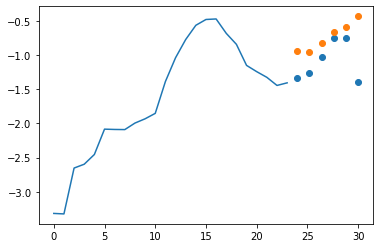

In [237]:
z = np.linspace(past, past+future,future)
plt.plot(test_temp[0])
plt.scatter(z,test_label[0])
plt.scatter(z,y_predict_WAV_reshaped[0])

# Model comparison


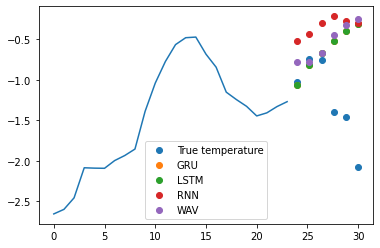

In [238]:
i = 2
z = np.linspace(past, past+future,future)
plt.plot(test_temp[i])
#plt.scatter(z,y_predict[i], label = 'NN')
plt.scatter(z,test_label[i], label = 'True temperature')
#plt.scatter(z,y_persistence[i], label= 'Persistence')
#plt.scatter(z,predict_label[i], label='Linear regression')
plt.scatter(z,y_predict_GRU_reshaped[i], label='GRU')
plt.scatter(z,y_predict_LSTM_reshaped[i], label='LSTM')
plt.scatter(z,y_predict_RNN_reshaped[i], label='RNN')
plt.scatter(z,y_predict_WAV_reshaped[i], label='WAV')

plt.legend(loc='best')



## MSE

> We will check how MSE grows for predicted value on time axis.

In [239]:
def mse(predict):
  mse = np.ones((future,))
  for i in range(future):
     mse[i]= np.mean((test_label[:,i]-predict[:,i])**2)
  return mse 
   

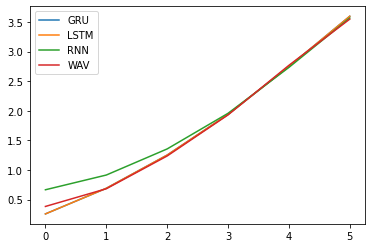

In [240]:
#plt.plot(mse(y_predict), label = 'NN')
#plt.plot(mse(predict_label), label = 'Linear Regression')
#plt.plot(mse(y_persistence), label = 'Persistence')
plt.plot(mse(y_predict_GRU_reshaped), label = 'GRU')
plt.plot(mse(y_predict_LSTM_reshaped), label = 'LSTM')
plt.plot(mse(y_predict_RNN_reshaped), label = 'RNN')
plt.plot(mse(y_predict_WAV_reshaped), label = 'WAV')
plt.legend(loc='best')

# Comparison with Baseline models

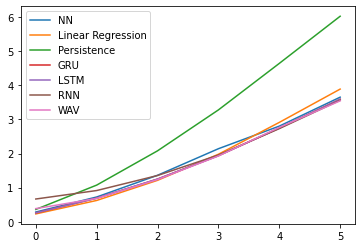

In [241]:
plt.plot(mse(y_predict), label = 'NN')
plt.plot(mse(predict_label), label = 'Linear Regression')
plt.plot(mse(y_persistence), label = 'Persistence')
plt.plot(mse(y_predict_GRU_reshaped), label = 'GRU')
plt.plot(mse(y_predict_LSTM_reshaped), label = 'LSTM')
plt.plot(mse(y_predict_RNN_reshaped), label = 'RNN')
plt.plot(mse(y_predict_WAV_reshaped), label = 'WAV')
plt.legend(loc='best')

12Hrs Data

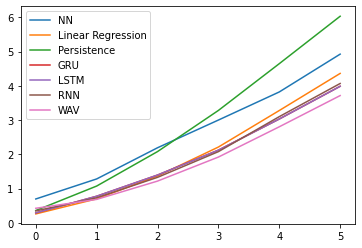

24 hrs data

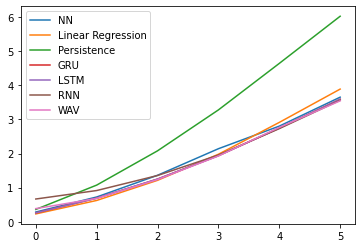

# Conclusion

> The networks designed for time series have much lesser parameters and perform significantly better than the simple models. In our multiple runs, wavnet inspired model outperformed other networks multiple times.